# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
%load_ext autoreload
%autoreload 2
from zip_code_funct import ZipCode_TSA

import pickle

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv('zillow_data.csv')

# Step 2: Change the format of the dataset from wide to long

In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

df = pd.read_csv('zillow_data.csv')
df = df.drop(labels=['SizeRank','Metro', 'RegionID'], axis = 1)
df_long = melt_data(df)
df_long.rename(columns={'RegionName' : 'ZipCode'},inplace=True)

# Step 3: Slice the all zipcodes

In [19]:
all_zipcodes = list(df['RegionName'])

# Step 4: Check how the ARIMA model works for one zipcode

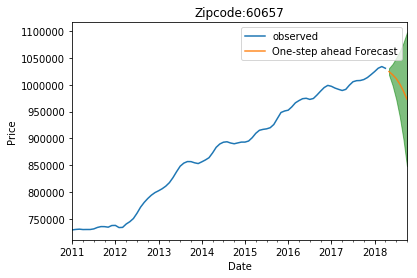

In [6]:
zipcode_60657 = ZipCode_TSA(df_long, 60657, '2011')

pred_conf = zipcode_60657.prediction_conf()

#Plot observed values
ax = zipcode_60657.df_zipcode()['value'][zipcode_60657.start_date:].plot(label='observed')

#Plot predicted values
pred_conf[0].predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf[1].index,
                pred_conf[1].iloc[:, 0],
                pred_conf[1].iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Zipcode:60657')
plt.legend()

plt.show()


In [ ]:
zipcode_75070 = ZipCode_TSA(df_long, 75070, '2011')

pred_conf = zipcode_75070.prediction_conf()

#Plot observed values
ax = zipcode_75070.df_zipcode()['value'][zipcode_75070.start_date:].plot(label='observed')

#Plot predicted values
pred_conf[0].predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf[1].index,
                pred_conf[1].iloc[:, 0],
                pred_conf[1].iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Zipcode:75070')
plt.legend()

plt.show()



In [ ]:
zipcode_77494 = ZipCode_TSA(df_long, 77494, '2011')

pred_conf = zipcode_77494.prediction_conf()

#Plot observed values
ax = zipcode_77494.df_zipcode()['value'][zipcode_77494.start_date:].plot(label='observed')

#Plot predicted values
pred_conf[0].predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf[1].index,
                pred_conf[1].iloc[:, 0],
                pred_conf[1].iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Zipcode:77494')
plt.legend()

plt.show()



# Step 5: Apply the ARIMA model for top 1000 zipcode 

In [ ]:
# zipcode_77494 = ZipCode_TSA(df_long, 77494, '2011')
# (77494, zipcode_77494.forecast())


In [20]:
# result_list = []
# for zipcode in all_zipcodes:
#     temp = ZipCode_TSA(df_long, zipcode, '2015')
#     result = temp.forecast() 
#     result_list.append((zipcode, result))


In [11]:
# temp = ZipCode_TSA(df_long, 75070, '2015')

In [12]:
# %prun temp.forecast()

In [21]:
len(result_list)

14723

In [22]:
result_list

[(60657,
  (-216894.3650403167, 49936.03962984169, -503479.0263028309, 1030600.0)),
 (75070,
  (-21097.214510408754, 33310.392687868676, -76127.19755449356, 321800.0)),
 (77494,
  (17079.39245625038, 55501.33538956195, -16013.413466330036, 329900.0)),
 (60614,
  (-126988.05893401173, 50187.90951524745, -315850.558877168, 1307000.0)),
 (79936,
  (2486.523791027139, 10813.820604683424, -4912.716796034569, 121500.0)),
 (77084,
  (3101.5229396833747, 17278.035923358286, -9839.337094769406, 164300.0)),
 (10467,
  (14498.16132939898, 111232.23553360254, -75953.97231825709, 417900.0)),
 (60640,
  (-98764.80905870965, 222334.61328206863, -427905.91584602353, 782800.0)),
 (77449,
  (2139.5039572178794, 13456.97211074541, -8063.821922636795, 176200.0)),
 (94109,
  (431100.846247694, 1454759.8151428914, -512450.9840341164, 3813500.0)),
 (11226, (261860.26913881826, 558427.9802664656, 25699.22510349448, 963200.0)),
 (32162,
  (249.40153730724705, 52322.58934877458, -48089.321523844905, 251800.0)),

In [25]:
# with open('zipcodes_forcast.pkl', 'wb') as f:
#     pickle.dump(result_list, f)

In [27]:
with open('zipcodes_forcast.pkl', 'rb') as f:
    result_list = pickle.load(f)

In [76]:
list(result_list[0][1])

[-216894.3650403167, 49936.03962984169, -503479.0263028309, 1030600.0]

In [60]:
[result_list[0][0]]

[60657]

In [ ]:
zip_df = [[list(result_list[0][1])] for x in result_list]

In [75]:
dict_zipcode = {'zipcode': [i for range(0, len(result_list)+1) in result_list[i]]}

SyntaxError: can't assign to function call (<ipython-input-75-ab99b434d952>, line 1)

In [72]:
dict_zipcode

{'zipcode': [60657,
  (-216894.3650403167, 49936.03962984169, -503479.0263028309, 1030600.0)]}

In [49]:
flattened = []
[flattened.append(list(result_list[x][1])) for x in result_list]

TypeError: list indices must be integers or slices, not tuple

In [44]:
flattened

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [31]:
zip_df = pd.DataFrame(result_list, columns=['target', 'max_gain', 'max_loss', 'start_point'])

AssertionError: 4 columns passed, passed data had 2 columns

# Step 6: Interpret the results

CONTRIBUTING.md              mod_4_starter_notebook.ipynb
LICENSE.md                   starter_notebook
README.md                    zillow_data.csv
__pycache__                  zip_code_funct.py
images                       zipcodes_forcast.pkl
index.ipynb
